# Analysis for music therapy intervention

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal
import seaborn as sns
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (15,10)})

# import helper functions
from src.utls import prep_raw_data, prep_raw_data_pca, save_raw_tf_plt, save_raw_tf_plt_pca

## set enviroment and find relevant datasets

In [2]:
# (import) helper functions
dir_proj = Path("__file__").absolute().parents[1]
dir_rawdata = Path.joinpath(dir_proj, "data")
dir_prep = Path.joinpath(dir_proj,"results")
dir_single_plots = Path.joinpath(dir_proj,"results","single_subs_raw")
dir_single_plots.mkdir(exist_ok=True)
print(dir_rawdata)


c:\Users\User\Desktop\kiel\tremor_music_ap\data


In [3]:
# find all videos in path
f_list = os.listdir(dir_rawdata)
str_match = 'BS'
dir_patients = [s for s in f_list if str_match in s]

## set config variables and match numeric coded parameters

In [4]:
# define cfg vars
cfg_srate = 100
cfg_group = {1:"Standard & exp. music", 2:"Standard & unspecific music", 3: "Only Standard", 4: "Placebo"}
cfg_task = {1: "Standing flexed", 2:"Sitting flexed", 3: "Sitting relaxed"}
cfg_visit = {0: "Inital", 1: "14-days", 2: "Follow-up"}


## run preprocessing per subject
This loop find all subject dirctories, and all containing '.xslx' files. In the file name, task and visit are coded. Rawdata is split per accelerometer axis and filtered between 1-15 Hz and zero meaned. Main movement direction could be determined using PCA.
Resulting data is prepared to be converted into pandas df.

In [10]:
# set params for epoch processing and plotting

cfg_filter_window = [4,8]
cfg_freqs_oi = [3,9]


# prelocate df
# single time series
id = []
visit = []
task = []
axis = []
freq = []
pow = []

# aggregate time series info
id_all = []
visit_all = []
task_all = []
axis_all = []
peak_amp = []
peak_freq = []

tmp_dir_patients = dir_patients

for dir_sub in tqdm(tmp_dir_patients):
    nms_files = os.listdir(Path.joinpath(dir_rawdata,dir_sub))

    for fnm in nms_files:
        tmp = pd.read_excel(Path.joinpath(dir_rawdata,dir_sub,fnm),header=None)

        # extract visit specific info
        tmp_id = dir_sub.replace(' ','')
        tmp_visit = fnm.split(' - ')[1]
        tmp_task = fnm.split('prova ')[1][0]
        if len(tmp_visit) > 2:
            print(f"Processing visit {tmp_visit} from {tmp_id}")
            break


        # process raw data
        x = tmp.iloc[:,0]
        y = tmp.iloc[:,1]
        z = tmp.iloc[:,2]

        x_zm, freq_x , spec_x = prep_raw_data(x, cfg_srate, cfg_filter_window[0], cfg_filter_window[1])
        y_zm, freq_y , spec_y = prep_raw_data(y, cfg_srate, cfg_filter_window[0], cfg_filter_window[1])
        z_zm, freq_z , spec_z = prep_raw_data(z, cfg_srate, cfg_filter_window[0], cfg_filter_window[1])

        # freq estimation with pca
        pca_zm, freq_pca , spec_pca, eigenratios = prep_raw_data_pca(tmp, cfg_srate)

        # append data
        n_freqs = len(freq_pca)

        # single time series
        id.extend( [tmp_id] * n_freqs)
        visit.extend( [tmp_visit] * n_freqs)
        task.extend( [tmp_task] * n_freqs)

        freq.extend(freq_pca)
        pow.extend(spec_pca)

        # aggregate time series info
        id_all.extend([tmp_id])
        visit_all.extend([tmp_visit])
        task_all.extend([tmp_task])
        axis_all.extend(['pca'])

        idx_max_amp_pca = np.argmax(spec_pca)

        peak_amp.append(spec_pca[idx_max_amp_pca])

        peak_freq.append(freq_pca[idx_max_amp_pca])

        if tmp_task == "3":
            save_raw_tf_plt_pca(x_zm, y_zm, z_zm, pca_zm, eigenratios, cfg_srate, cfg_freqs_oi, tmp_id, dir_single_plots)





100%|██████████| 42/42 [00:59<00:00,  1.42s/it]


In [9]:
tmp_task

'3'

## aggregate preprocessed data to dataframes

In [ ]:
single_sub = pd.DataFrame(list(zip(id,visit,task,axis,freq,pow)), columns=["id","visit","task","axis","frequency","power"])
agg_data = pd.DataFrame(list(zip(id_all,visit_all,task_all,axis_all,peak_freq,peak_amp)), columns=["id","visit","task","axis","peak frequency","peak amplitude"])

## remapping from numeric coded parameters and saved

In [ ]:
single_sub["visit"] = single_sub["visit"].astype(int).map(cfg_visit)
single_sub["task"] = single_sub["task"].astype(int).map(cfg_task)

agg_data["visit"] = agg_data["visit"].astype(int).map(cfg_visit)
agg_data["task"] = agg_data["task"].astype(int).map(cfg_task)

In [ ]:
single_sub.to_csv(Path.joinpath(dir_prep,"single_subj_pow.csv"), index=False)
agg_data.to_csv(Path.joinpath(dir_prep,"single_subj_agg.csv"), index=False)

## exploratory plots

The next plot gives an example of the high variance over time for a specific subjects tremor

(2.0, 6.0)

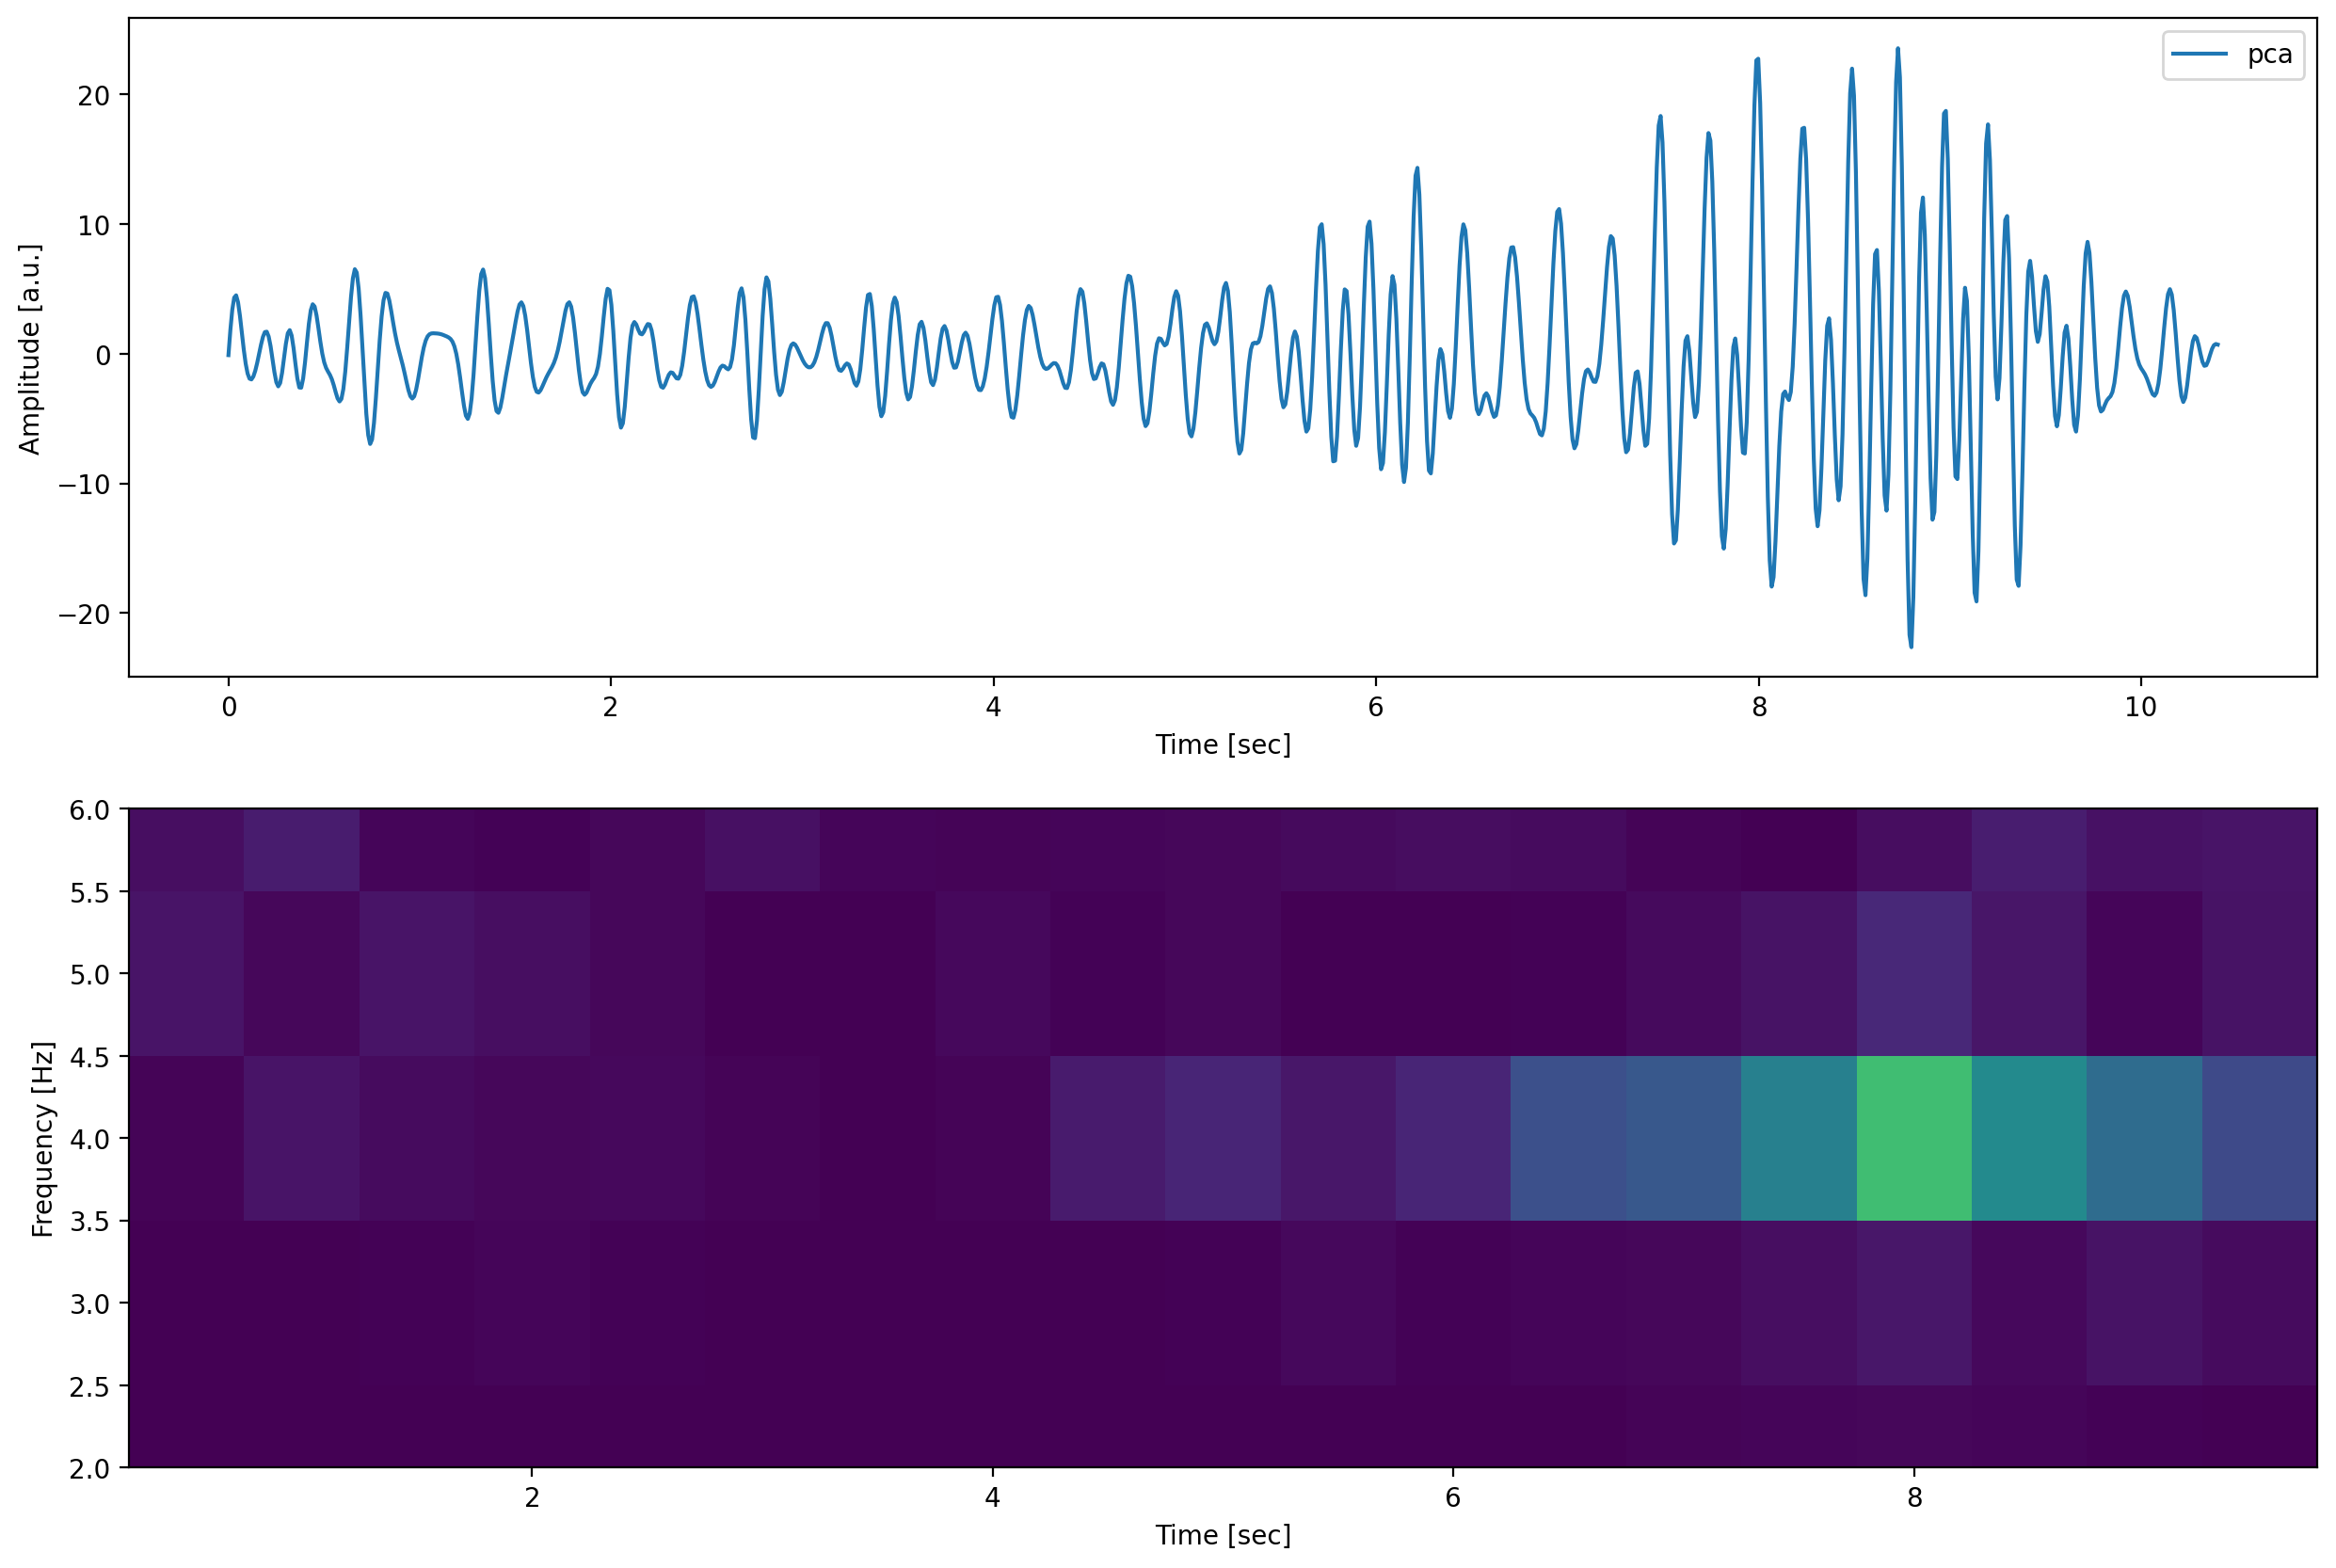

In [ ]:
freqs, times, specs_pca = signal.spectrogram(pca_zm, cfg_srate, nperseg = cfg_srate, noverlap = cfg_srate // 2)

fig,axs = plt.subplots(2,1)

time_vec = np.linspace(0,len(pca_zm) / cfg_srate, len(pca_zm))
axs[0].plot(time_vec,pca_zm,label='pca')

axs[0].set_ylabel('Amplitude [a.u.]')
axs[0].set_xlabel('Time [sec]')
axs[0].legend()

axs[1].pcolormesh(times, freqs,np.array([specs_pca]).sum(axis=0), shading='nearest')
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_xlabel('Time [sec]')
axs[1].set_ylim([2,6])
